# Measuring Forecasting Error

In [291]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load datasets

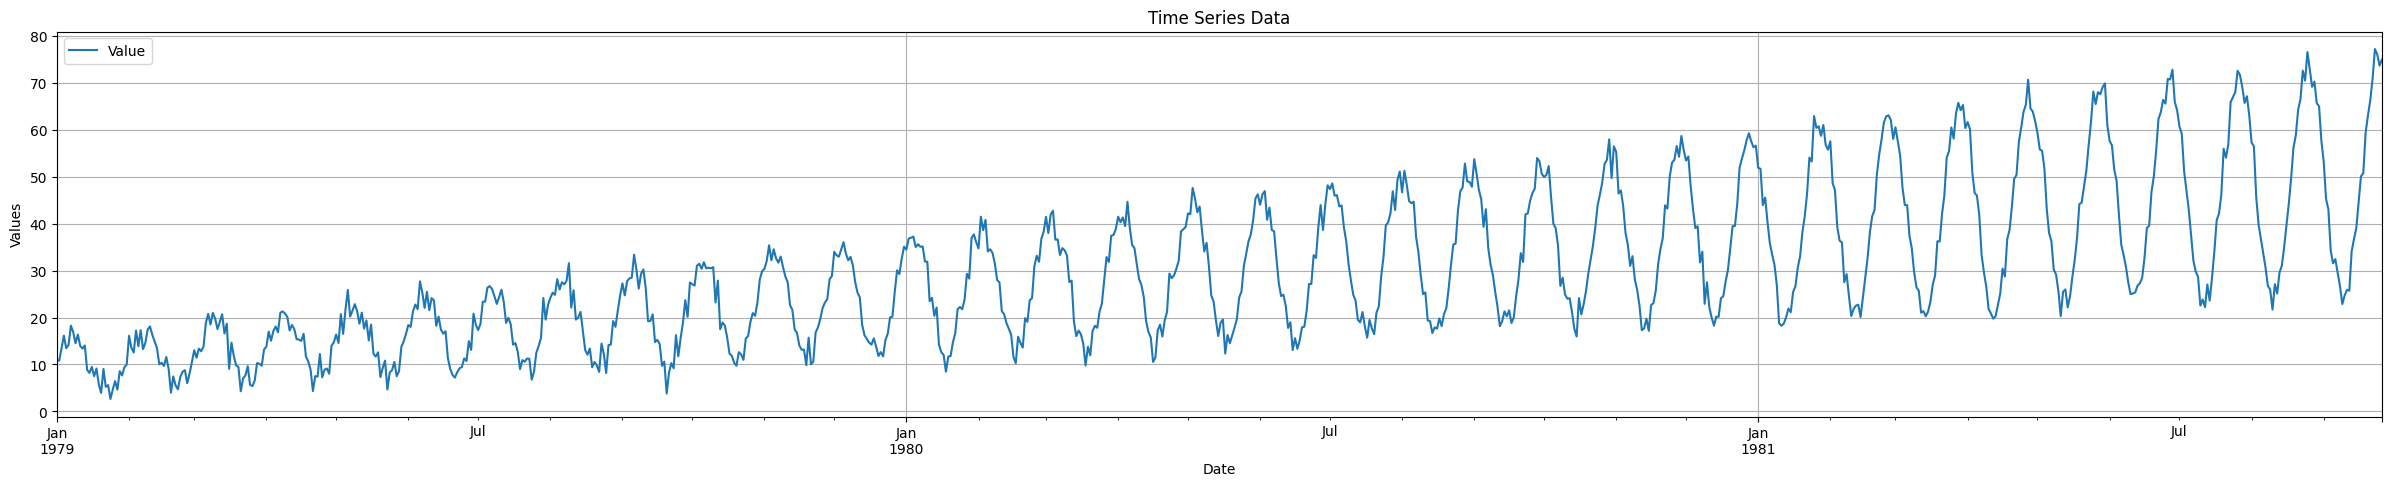

In [292]:
# Load dataset

ts = pd.read_csv('https://raw.githubusercontent.com/renatomaaliw3/public_files/master/Data%20Sets/classified_ts_11.csv',
                      index_col = 'Date', parse_dates = True)

ts.plot(figsize = (30,5), grid = True, ylabel = 'Values', title = 'Time Series Data')
plt.show()

### Check for trend and seasonality

In [293]:
# STL Decomposition

from statsmodels.tsa.seasonal import STL

ts_stl = STL(ts["Value"], robust = True)  # Robust = better handling of outliers
decomp_stl = ts_stl.fit()

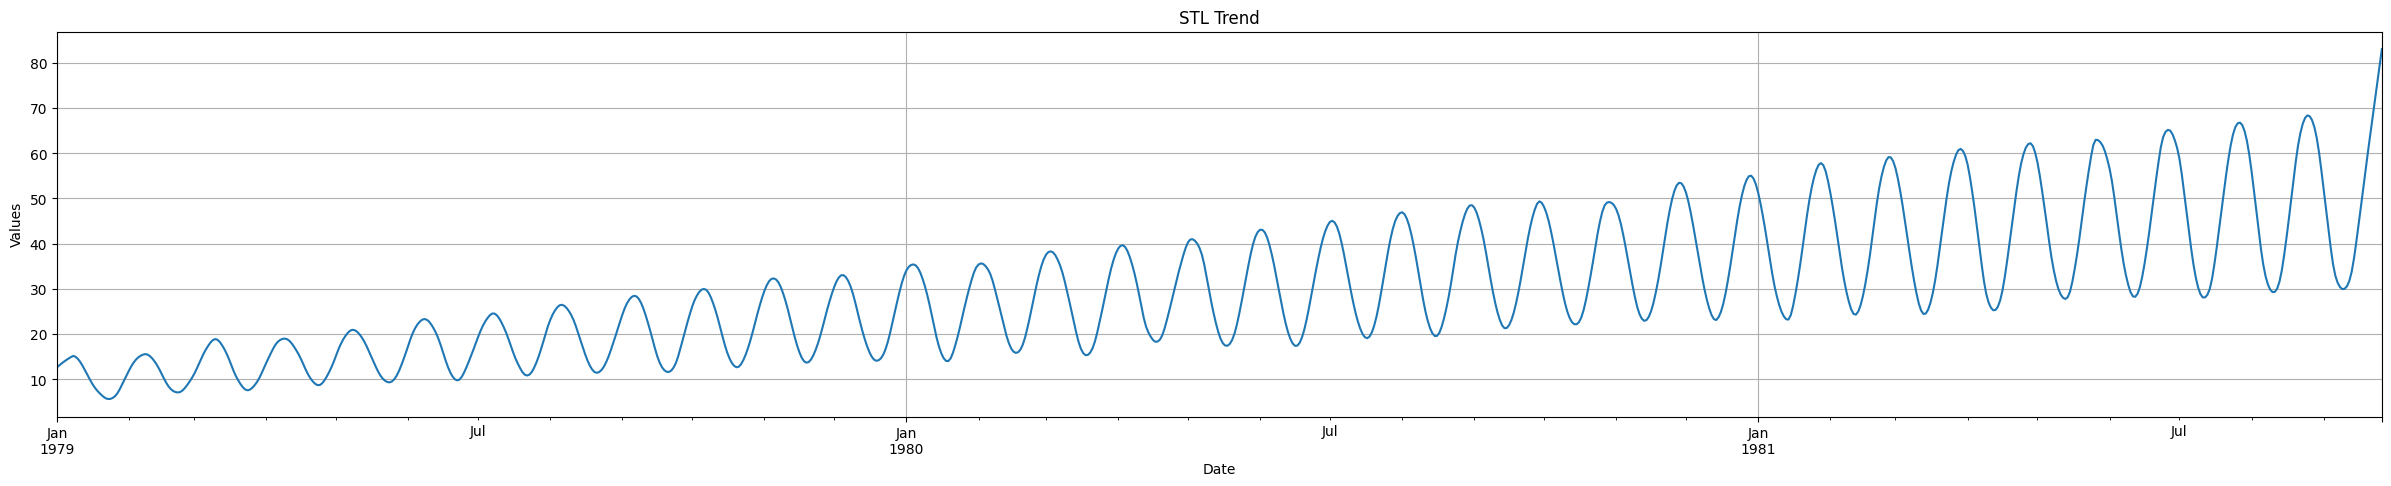

In [294]:
# STL Trend

decomp_stl.trend.plot(figsize = (30,5), grid = True, ylabel = 'Values', title = 'STL Trend')
plt.show()

# It has a clear trend (upward, additive)

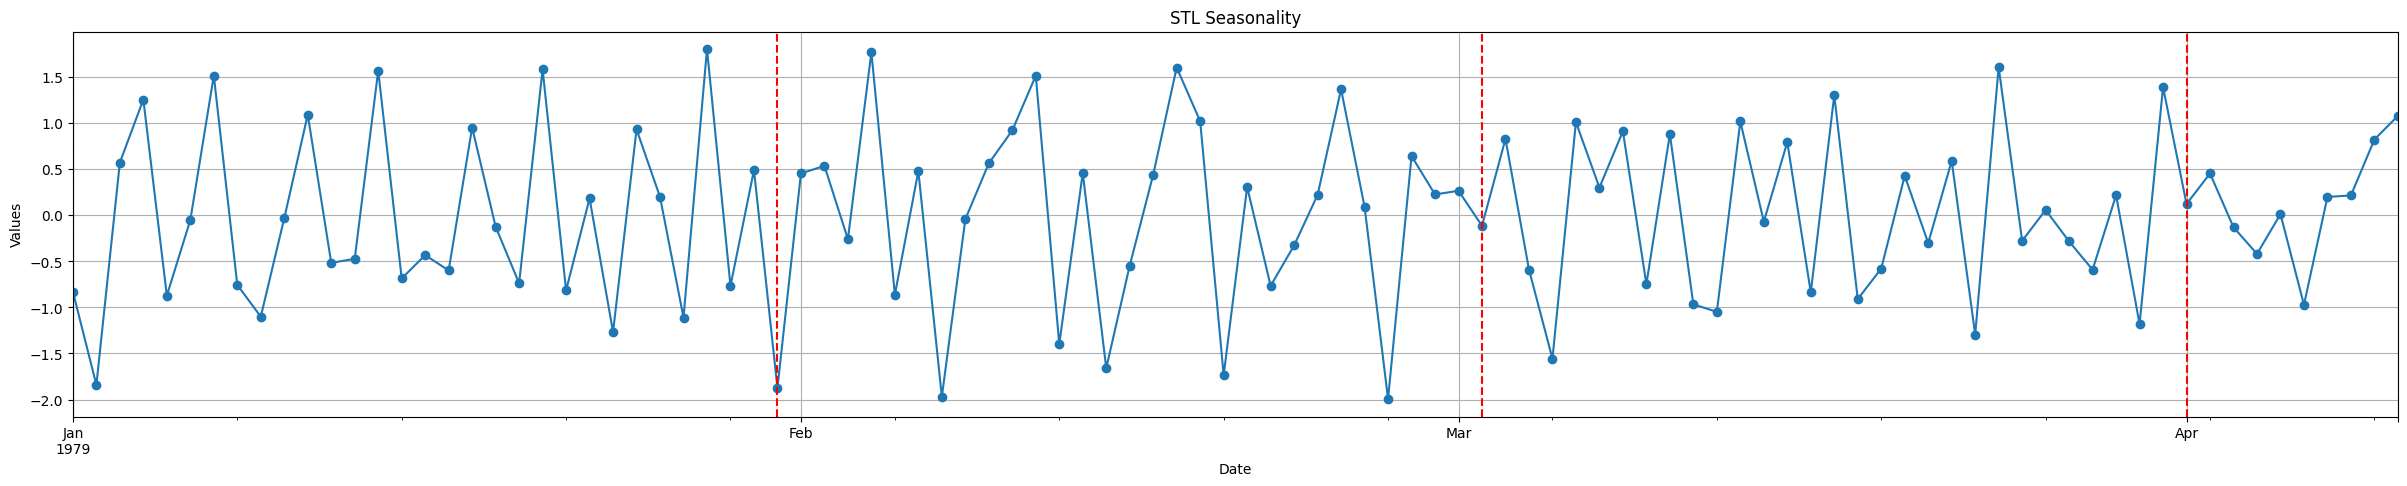

In [295]:
# STL Seasonality

fig, ax = plt.subplots(figsize=(25, 4))
decomp_stl.seasonal[:100].plot(ax = ax, figsize = (30,5), grid = True, ylabel = 'Values', title = 'STL Seasonality', marker = 'o')

for day in range(0, 100, 30):

 ax.axvline(x = decomp_stl.seasonal.index[day], color = 'red', linestyle = '--')

plt.show()

# There is a clear seasonality

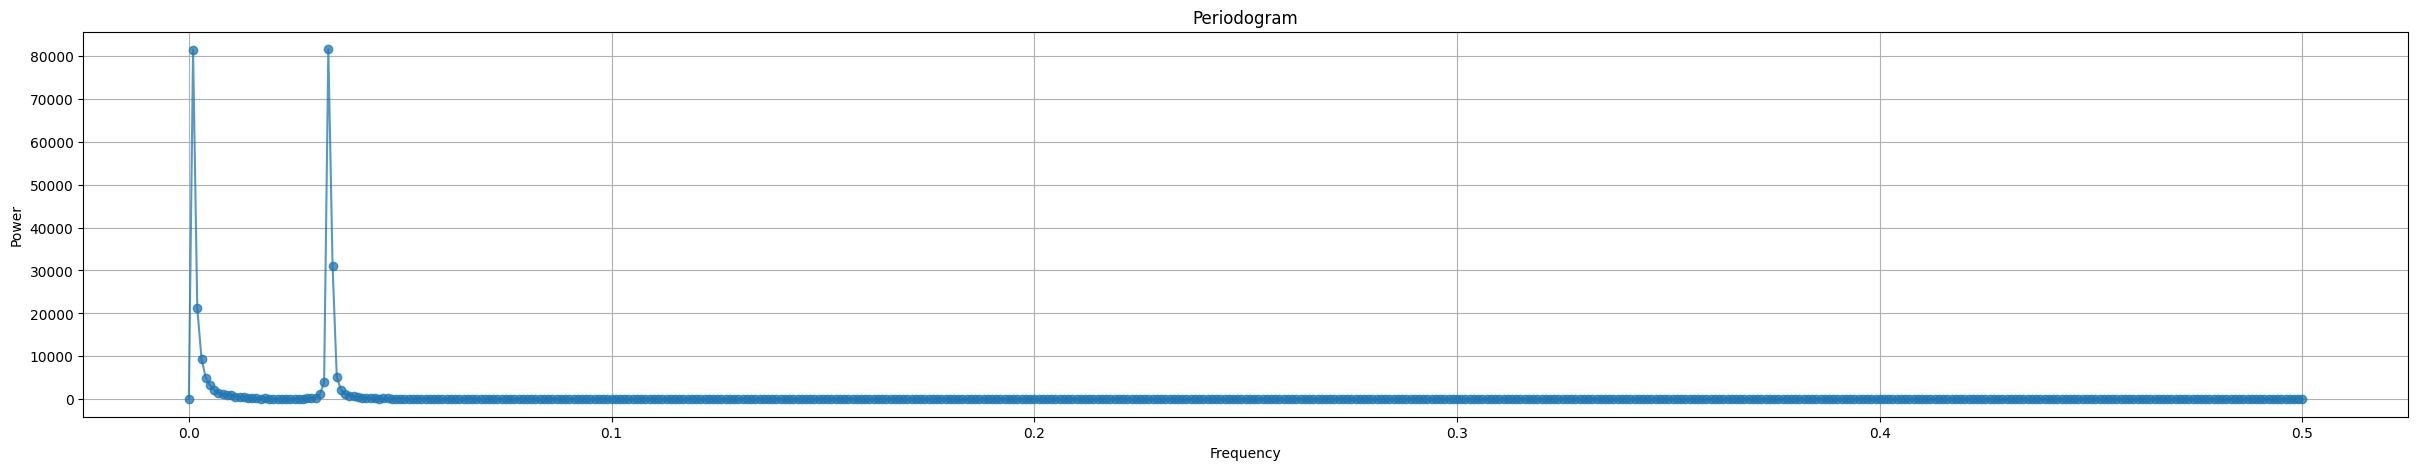

In [296]:
# Periodogram (for Seasonality)

from scipy.signal import periodogram

# Compute the periodogram
frequencies, power = periodogram(ts['Value'])

# Plot the periodogram
plt.figure(figsize=(30, 5))
plt.plot(frequencies, power, marker='o', linestyle='-', alpha = 0.75)
plt.title("Periodogram")
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.grid(True)
plt.show()

# There is a seasonality, what is it?

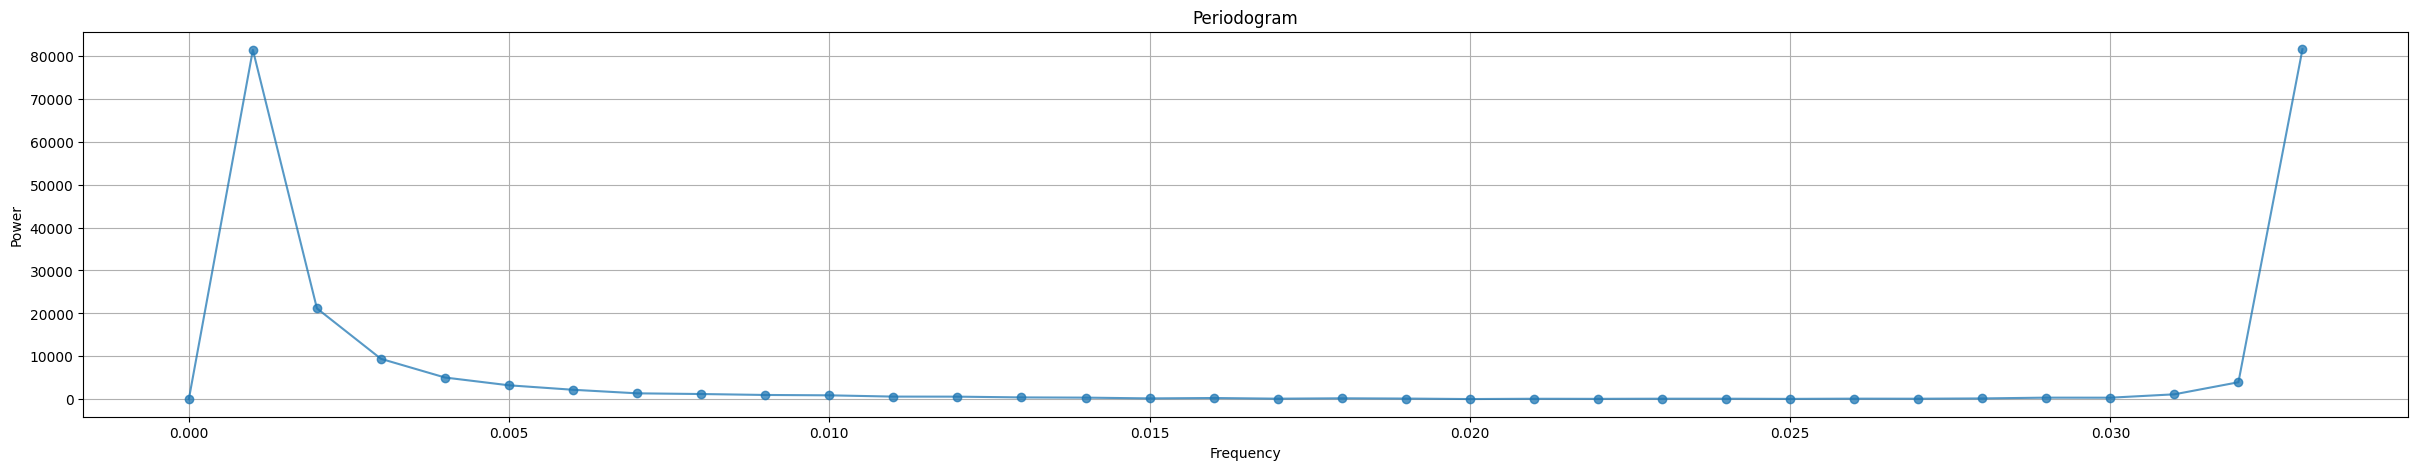

In [297]:
# Periodogram (for Seasonality)

# Plot the periodogram
plt.figure(figsize=(30, 5))
plt.plot(frequencies[:34], power[:34], marker='o', linestyle='-', alpha = 0.75)
plt.title("Periodogram")
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.grid(True)
plt.show()

# Close to 30

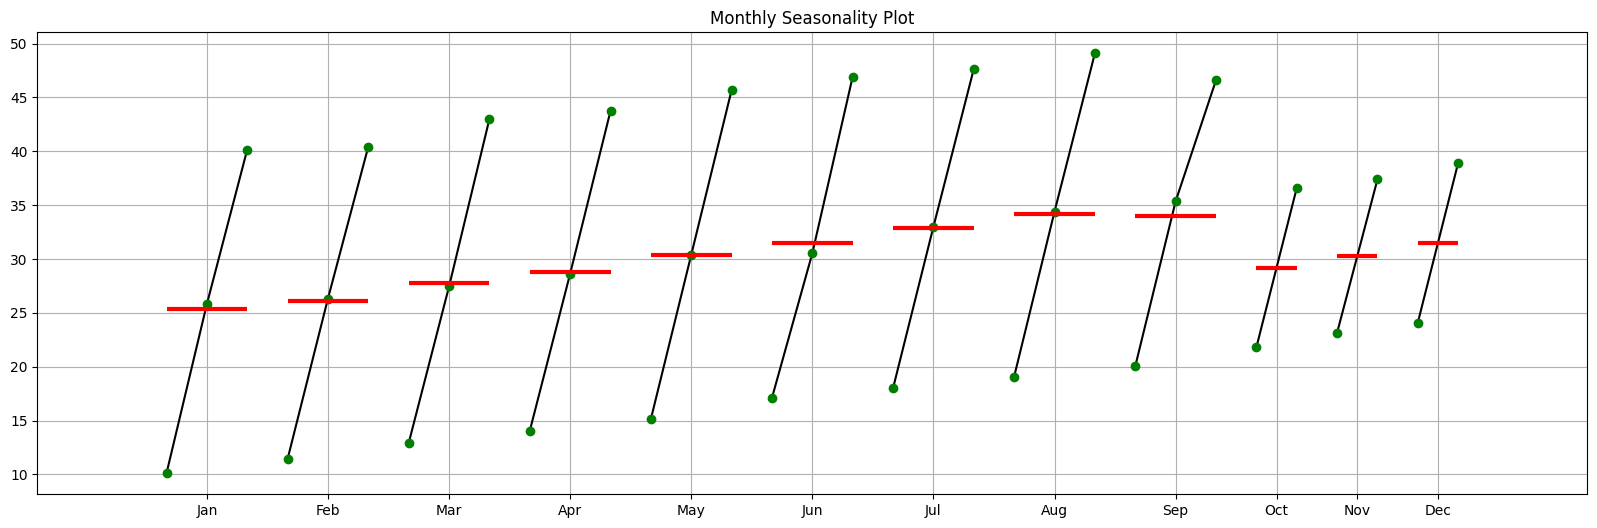

In [298]:
# Month Plots

from statsmodels.graphics.tsaplots import month_plot

ts_monthly = ts['Value'].resample('MS').mean()

fig, ax = plt.subplots(figsize=(20, 6))
month_plot(ts_monthly, ax = ax)
plt.title("Monthly Seasonality Plot")
plt.grid()

for line in ax.get_lines():

  line.set_marker('o')
  line.set_markerfacecolor('green')
  line.set_markeredgecolor('green')

plt.show()

# The black lines represent monthly disribution of values
# The red lines is the mean values for each month

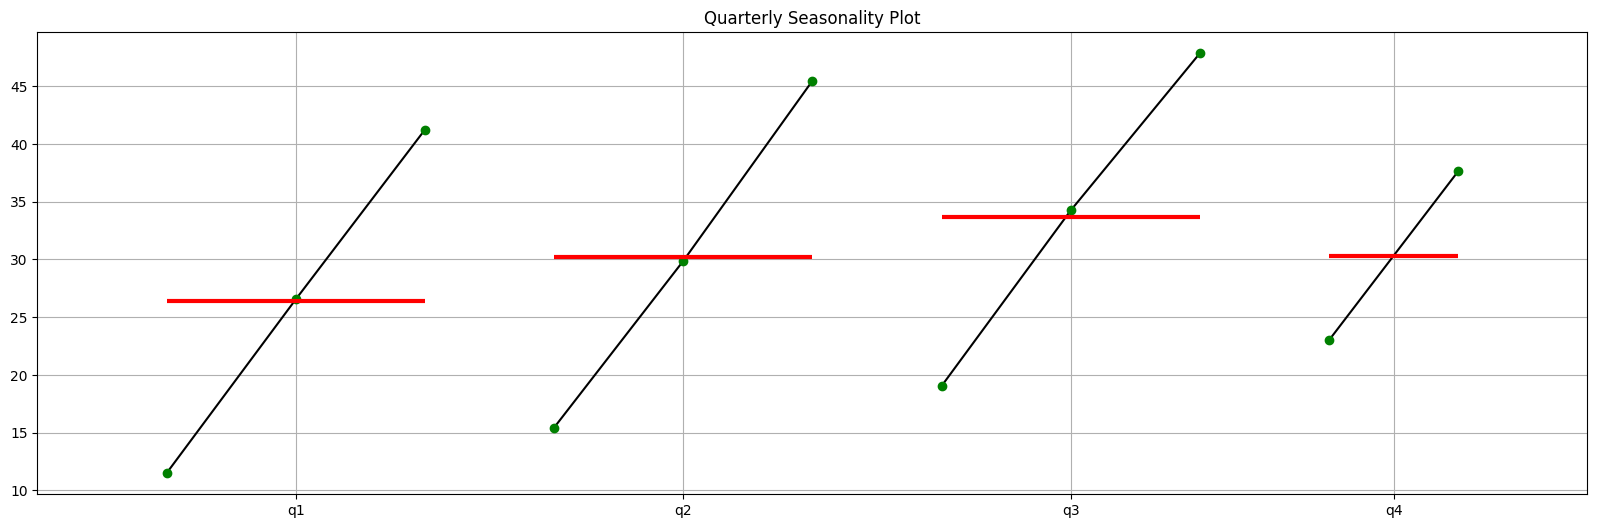

In [299]:
# Quarter Plots

from statsmodels.graphics.tsaplots import quarter_plot

ts_quarter = ts['Value'].resample('QE').mean()

fig, ax = plt.subplots(figsize=(20, 6))
quarter_plot(ts_quarter, ax = ax)
plt.title("Quarterly Seasonality Plot")
plt.grid()

for line in ax.get_lines():

  line.set_marker('o')
  line.set_markerfacecolor('green')
  line.set_markeredgecolor('green')

plt.show()

# The black lines represent quarterly disribution of values
# The red lines is the mean values for each quarter

### Forecasting Using TES

#### 1. Select a Model

In [300]:
# We will use Double Exponential Smoothing

from statsmodels.tsa.holtwinters import ExponentialSmoothing

#### 2. Split data into train & test sets

In [301]:
# Splitting

forecast_horizon = 12 # or periods

train_data = ts.iloc[:-forecast_horizon] # data except the last 12 months
test_data = ts.iloc[-forecast_horizon:] # select the last 12 months

train_data = train_data.asfreq('D')
test_data = test_data.asfreq('D')

#### 3. Fit model on training set

In [302]:
tes_model = ExponentialSmoothing(train_data['Value'], trend = 'additive', seasonal = 'additive', seasonal_periods = 30).fit()

# tes_model_.summary()

#### 4. Evaluate model on test set (visually first)

In [303]:
# Forecast/Predict based on train_data

tes_pred = tes_model.forecast(forecast_horizon)
tes_pred

,0
1981-09-15,41.872543
1981-09-16,45.137333
1981-09-17,50.042427
1981-09-18,56.542737
1981-09-19,58.566893
1981-09-20,63.523809
1981-09-21,67.610705
1981-09-22,71.718811
1981-09-23,70.884294
1981-09-24,75.983671


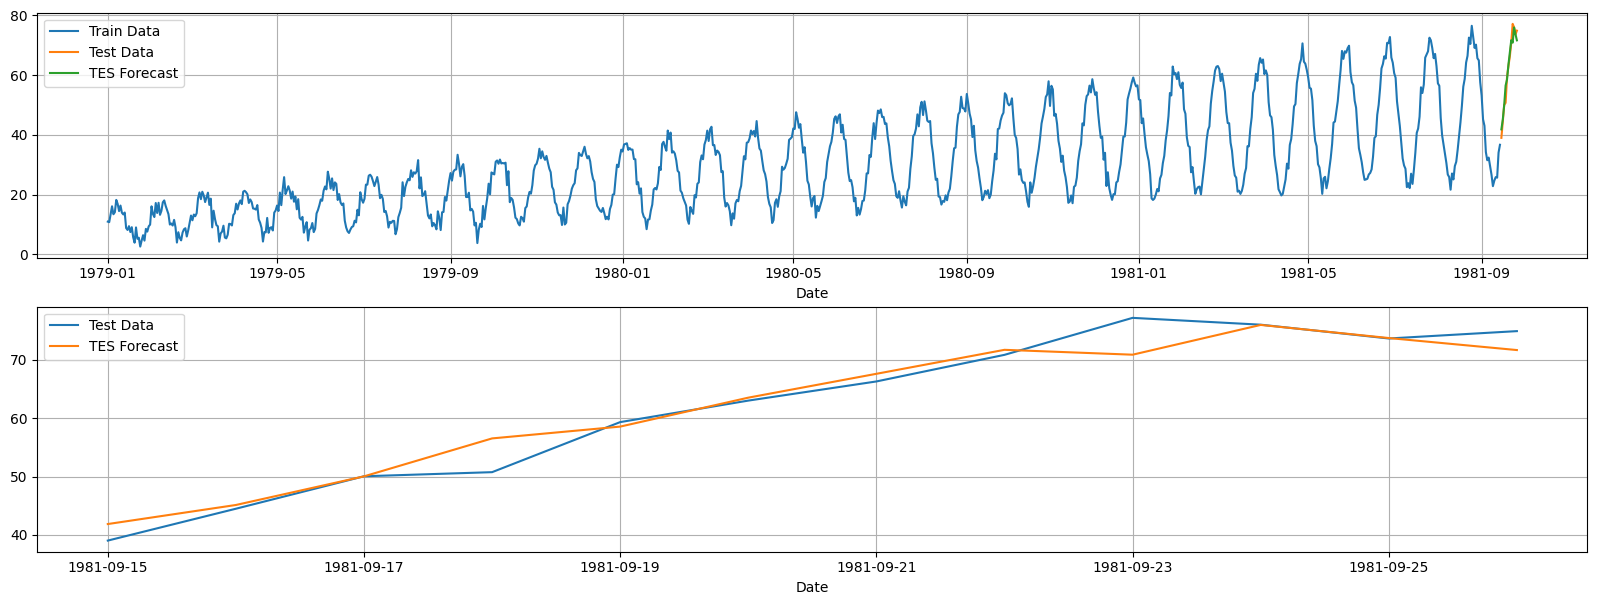

In [304]:
# Visualization

plt.figure(figsize = (20, 7))

plt.subplot(2, 1, 1)
plt.plot(train_data.index, train_data['Value'], label = 'Train Data')
plt.plot(test_data.index, test_data['Value'], label = 'Test Data')
plt.plot(tes_pred.index, tes_pred, label = 'TES Forecast')
plt.legend()
plt.grid()
plt.xlabel('Date')

plt.subplot(2, 1, 2)
plt.plot(test_data.index, test_data['Value'], label = 'Test Data')
plt.plot(tes_pred.index, tes_pred, label = 'TES Forecast')
plt.legend()
plt.grid()
plt.xlabel('Date')
plt.show()

### Measuring Forecast Error

In [305]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

print(f'MAE: {mean_absolute_error(test_data, tes_pred)}')
print(f'MSE: {mean_squared_error(test_data, tes_pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(test_data, tes_pred))}')
print(f'MAP: {mean_absolute_percentage_error(test_data, tes_pred)}')

MAE: 1.8654532794011949
MSE: 7.960201596759053
RMSE: 2.821382922745343
MAP: 0.03172069087507114


In [306]:
# Mean absolute Scaled Error
# !pip install sktime

from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

print(f'MASE: {mean_absolute_scaled_error(test_data, tes_pred, y_train = train_data)}')

MASE: 0.6374629425819541


In [318]:
# sMAPE

def smape_manual(y_true, y_pred):

    y_true, y_pred = np.array(test_data), np.array(tes_pred)
    denominator = np.abs(y_true) + np.abs(y_pred)
    return 100 * np.mean(np.abs(y_true - y_pred) / denominator)

print(f'sMAPE: {smape_manual(test_data, tes_pred)}')

sMAPE: 18.786072629309785


#### 6. Re-fit model on entire data set

In [308]:
# Notice we are using the entire dataset

ts = ts.asfreq('D')

tes_model = ExponentialSmoothing(ts['Value'], trend = 'additive', seasonal = 'additive', seasonal_periods = 30).fit()

7. Forecast for future data

In [309]:
# We forecast using the entire dataset

tes_pred = tes_model.forecast(forecast_horizon)
tes_pred

,0
1981-09-27,70.308731
1981-09-28,67.552582
1981-09-29,65.296075
1981-09-30,59.803712
1981-10-01,55.831218
1981-10-02,48.351314
1981-10-03,44.406333
1981-10-04,38.108268
1981-10-05,34.757104
1981-10-06,33.770362


Text(0.5, 0, 'Date')

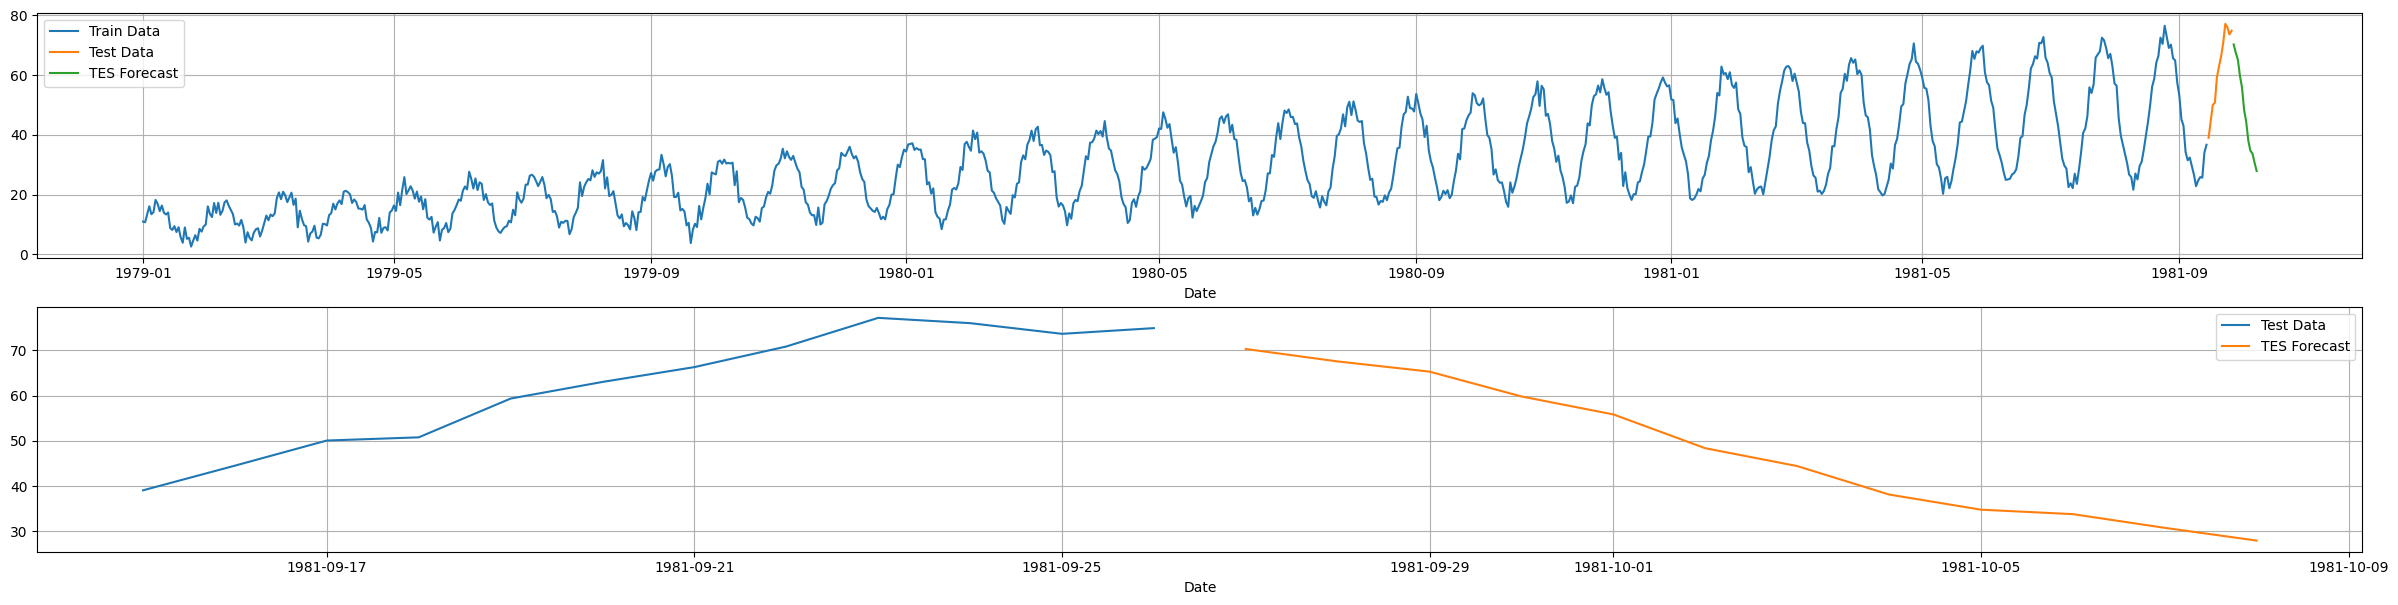

In [310]:
# Visualization

plt.figure(figsize = (30, 7))

plt.subplot(2, 1, 1)
plt.plot(train_data.index, train_data, label = 'Train Data')
plt.plot(test_data.index, test_data, label = 'Test Data')
plt.plot(tes_pred.index, tes_pred, label = 'TES Forecast')
plt.legend()
plt.grid()
plt.xlabel('Date')

plt.subplot(2, 1, 2)
plt.plot(test_data.index, test_data, label = 'Test Data')
plt.plot(tes_pred.index, tes_pred, label = 'TES Forecast')
plt.legend()
plt.grid()
plt.xlabel('Date')